Ce notebook introduit l'utilisation de réseaux de neurones pour la représentation implicite de fonctions dans le but d'interpoler les frames d'une image d'IRM dynamique. Il est conseillé de créer un environnement dédié avec les éléments suivants:   
-pytorch   
-numpy   
-nibabel (pour la manipulation des images irm)   
-tinycudann   
   
Nous allons voir trois familles de modèle différentes; Fourier features, Siren, Hash encoding

In [1]:
#Nous importons les modules classiques

import torch #bibliothèque de deep learning
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import nibabel as nib
import math
import tinycudann as tcnn



/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Commençons par charger l'image d'IRM 4D

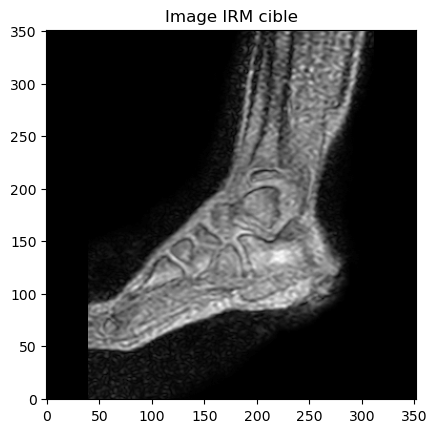

In [2]:
#Première étape, charger une image IRM
image_path = '/mnt/Data/Equinus_BIDS_dataset/sourcedata/sub_E01/sub_E01_dynamic_MovieClear_active_run_12.nii.gz'
mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3, 7] #On visualise la 3 slice et la 7eme frame

plt.title('Image IRM cible')
plt.imshow(data.T, origin='lower', cmap='gray')

Nous créons maintenant le dataset et le dataloader. Les données sont normalisées entre 0 et 1, car nous allons commencer par utiliser un simple MLP avec des fonctions d'activation ReLU. Nous utiliserons un optimizer de type Adam, qui est le choix passe partout pour la plupart des modèles avant de passer à un optimizer plus spécialisé.  

Notez que dans le cadre des représentations implicites, l'image de référence est utilisée pour le calcul de la loss, mais pas comme point d'entrée du réseau. Ceci est en opposition avec le cas plus classique des réseaux convolutifs. Dans cet exemple, seules les coordonnées (x, y) sont prises en entrée du réseau. Plus formellement, on cherche à approximer la fonction f(x, y) = I avec I intensité de l'image au point (x, y) grâce à la paramétrisation Φ(x). Nous approximons la fonction grâce à la minimisation suivante: argmin ∫Ω∥Φ(x)−f(x)∥dx, Ω étant le domaine de l'image.

In [3]:
batch_size = 5000
epochs = 50
dim_hidden = 352

image_shape = data.shape
dim_in = len(data.shape)

#On tensorise nos données puis on normalise entre -1 et 1
Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max()

#Creation de la grille de coordonnées en points d'entrée
axes = []
for s in image_shape:
    axes.append(torch.linspace(0, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in) #Je tensorise la grille

dataset = torch.utils.data.TensorDataset(X, Y)  #une coordonnée est associée à une valeur y

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))
print(train_batch) #l'ordre des coordonnées est aléatoire, utilisé pour l'entrainement
print(test_batch) #l'ordre des coordonnées est croissant, utilisé pour les prédictions

[tensor([[0.6125, 0.1909],
        [0.2564, 0.0342],
        [0.6496, 0.4131],
        ...,
        [0.0142, 0.4302],
        [0.1425, 0.5442],
        [0.4103, 0.3362]]), tensor([[0.1266],
        [0.0633],
        [0.6203],
        ...,
        [0.0000],
        [0.0000],
        [0.6329]])]
[tensor([[0.0000, 0.0000],
        [0.0000, 0.0028],
        [0.0000, 0.0057],
        ...,
        [0.0399, 0.1966],
        [0.0399, 0.1994],
        [0.0399, 0.2023]]), tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])]


/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 746 K 
--------------------------------------
746 K     Trainable params
0         Non-trainable params
746 K     Total params
2.988     Total estimated model params size (MB)
/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 21.37it/s, loss=0.00489, v_num=399]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 20.88it/s, loss=0.00489, v_num=399]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 107.07it/s]


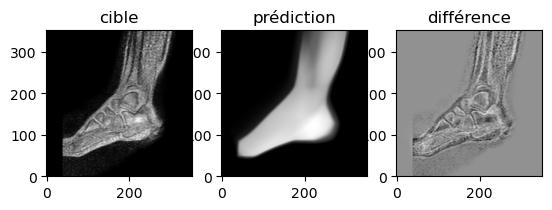

In [4]:
class MLP(pl.LightningModule):
    def __init__(self, dim_in, dim_hidden, dim_out, n_layers, lr):
        super().__init__()
        self.lr = lr
        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(in_features=dim_in if i == 0 else dim_hidden, out_features=dim_out if i == (n_layers - 1) else dim_hidden))
            layers.append(nn.ReLU())
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self(x)

        loss = F.mse_loss(z, y)
        
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
model = MLP(dim_in=len(data.shape), dim_hidden=dim_hidden, dim_out=1, n_layers=8, lr=1e-4)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32, #16 ou 32. 16 pour automated mixed precision, voir https://developer.nvidia.com/automatic-mixed-precision
)

trainer.fit(model, train_loader)

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

gt = data / data.max()

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()
        

Bien que le réseau converge, on voit bien que les détails de l'image (ce qu'on nomme les hautes fréquences) sont manquant. Pour remédier à ce problème, un certain nombre d'encodages du signal ont été proposé dans la littérature. L'un des principaux se base sur la transformé de Fourier. Dans l'exemple suivant, nous allons ajouter un simple module d'encodage de l'information et nous allons voir que les resultats sont bien plus probants en gardant un nombre de paramètres équivalent. L'encodage, dans ce cas, n'est pas paramétrisé ! Nous utilisons pour ce cas précis un encodage aléatoire, c'est à dire que les coefficients de Fourier sont tirés à partir d'un échantillonage normal. Mais d'autres encodages existent.

De manière plus formelle, on peut définir l'encodage comme suit: 
$\gamma(\mathbf{v}) = (\cos{2 \pi \mathbf{B} \mathbf{v}} , \sin{2 \pi \mathbf{B} \mathbf{v}})$

Avec:
$\mathbf{B}$ : Matrice de la taille du signal d'entrée et définie comme suit: $\mathcal{N}(0, \sigma^2)$

$\mathbf{v}$ : Signal d'entrée

Source: Tancik et al. "Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains"

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | GaussianEncoding | 0     
1 | decoder | Sequential       | 156 K 
---------------------------------------------
156 K     Trainable params
0         Non-trainable params
156 K     Total params
0.626     Total estimated model params size (MB)
/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 49: 100%|██████████| 25/25 [00:00<00:00, 37.56it/s, loss=0.000133, v_num=461]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:00<00:00, 37.02it/s, loss=0.000133, v_num=461]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 235.92it/s]


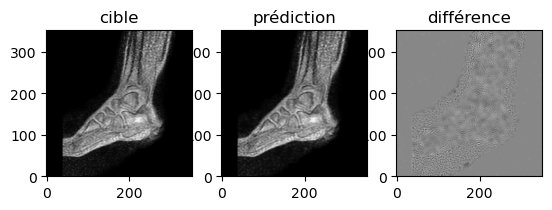

In [4]:
import rff

class FourierEncoding(pl.LightningModule):
    def __init__(self, dim_in, dim_hidden, dim_out, n_layers, n_frequencies, lr):
        super().__init__()
        self.lr = lr
        layers = []
        
        self.encoder = self.encoder = rff.layers.GaussianEncoding(sigma=10, input_size=dim_in, encoded_size=n_frequencies)
        encoding_dim_out = n_frequencies * 2
        
        for i in range(n_layers):
            layers.append(nn.Linear(in_features=encoding_dim_out if i == 0 else dim_hidden, out_features=dim_out if i == (n_layers - 1) else dim_hidden))
            layers.append(nn.ReLU())
            
        self.decoder = nn.Sequential(*layers)
        
    def forward(self, x):
        enco = self.encoder(x)
        inference = self.decoder(enco)
        return inference

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self(x)

        loss = F.mse_loss(z, y)
        
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
model = FourierEncoding(dim_in=len(data.shape), n_frequencies=len(data), dim_hidden=128, dim_out=1, n_layers=6, lr=1e-4)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32, #16 ou 32. 16 pour automated mixed precision, voir https://developer.nvidia.com/automatic-mixed-precision
)

trainer.fit(model, train_loader)

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

gt = data / data.max() 

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

On retrouve une image incluant les hautes fréquences, c'est à dire les détails de l'image.   
    
Dans cette exemple, l'encodage est tiré aléatoirement à partir d'une loi normal. Nous pouvons aller une étape plus loin et apprendre cet encodage grâce au prochain modèle, le Siren.

Un siren est un MLP dont les fonctions d'activations sont des fonctions périodiques. Concrètement, on remplace la ReLU usuellement utilisée par une fonction sin($\omega$ x). Notez l'absence de décodeur ainsi que la normalisation entre -1 et 1. Cette normalisation est nécessaire pour assurer la convergence optimum du modèle, puisque les fonctions d'activations évoluent également entre -1 et 1.

On cherche donc à paramétriser f(x) grâce aux coordonnées des pixels x via SIREN Φ(x). Ici, Φ(x) = Wn(Φn-1 * Φn-2 * ... * Φ0)(x) + Bn, et Φi = sin(Wi(x) + B(i)). Contrairement à l'exemple précédent, le coefficient de la fonction périodique est également appris. Plus particulièrement, il est à la fois appris et soumis à un hyperparamètre $\omega$ à ajuster manuellement.

On approxime cette fonction via la minimisation suivante : L=∫Ω∥Φ(x)−f(x)∥dx, Ω étant le domaine de l'image. Dans notre cas nous utilisons une mean square error de la forme L = 1 / n * Σ(1->n)||ŷn - yn||². 

Les sirens convergent très rapidement quand ils sont correctement initialisés, et présentent l'avantage d'être infiniments dérivables. Cette dernière propriété peut être utile pour utiliser des schémas de régularisation avancée, comme par exemple dans le papier "Implicit Neural Representations for Deformable Image Registration".

En revanche, ils sont très sensibles aux conditions d'initialisation et peuvent être délicats à entrainer correctement, surtout en dimensions supérieurs (4D et plus).

Il a été montré qu'un Siren à une couche est un réseau de Fourier dont les coefficients sont appris. Voir:  Bembarka et al."Seeing Implicit Neural Representations as Fourier Series"

In [6]:
#Première étape, charger une image IRM
image_path = '/mnt/Data/Equinus_BIDS_dataset/sourcedata/sub_E01/sub_E01_dynamic_MovieClear_active_run_12.nii.gz'
mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3, 7] #On visualise la 3 slice et la 7eme frame

batch_size = 5000
epochs = 50
dim_hidden = 352

image_shape = data.shape
dim_in = len(data.shape)

#On tensorise nos données puis on normalise entre -1 et 1
Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() * 2 - 1 

#Creation de la grille de coordonnées en points d'entrée
axes = []
for s in image_shape:
    axes.append(torch.linspace(-1, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in) #Je tensorise la grille

dataset = torch.utils.data.TensorDataset(X, Y)  #une coordonnée est associée à une valeur y

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

In [7]:
'''
Reference: Sitzmann et al, Implicit Neural Representations with Periodic Activation Functions

Notebook: https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb#scrollTo=39Mf3epV8Ib2

'''

#utilitaires pour Siren
def exists(val):
    return val is not None


def cast_tuple(val, repeat=1):
    return val if isinstance(val, tuple) else ((val,) * repeat)


class Sine(nn.Module):
    def __init__(self, w0=30.0):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)


class Siren(nn.Module):
    '''
    Une couche Siren
    ARGS:
        w0: facteur multiplicatif tel que f(x) = sin(w0 * x)
        c: spread des poids lors de l'initialisation de la couche. 
    '''
    def __init__(
        self,
        dim_in,
        dim_out,
        w0=30.0,
        c=6.0,
        is_first=False,
        use_bias=True,
        activation=None,
    ):
        super().__init__()
        self.dim_in = dim_in
        self.is_first = is_first

        weight = torch.zeros(dim_out, dim_in)
        bias = torch.zeros(dim_out) if use_bias else None
        self.init_(weight, bias, c=c, w0=w0)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias) if use_bias else None
        self.activation = Sine(w0) if activation is None else activation

    def init_(self, weight, bias, c, w0):
        dim = self.dim_in

        w_std = (1 / dim) if self.is_first else (math.sqrt(c / dim) / w0)
        weight.uniform_(-w_std, w_std)

        if exists(bias):
            bias.uniform_(-w_std, w_std)

    def forward(self, x):
        out = F.linear(x, self.weight, self.bias)
        out = self.activation(out)
        return out


# siren network
class SirenNet(pl.LightningModule):
    '''
    PURPOSE:
        Implicit representation of arbitrary functions. Mainly used for 2D, 3D image interpolation
    ATTRIBUTES:
        dim_in: dimension of input
        dim_hidden: dimmension of hidden layers. Value matching the size of the dimension of interest is recommended
        dim_out: dimension of output
        num_layers: number of layers
        w0: multiplying factor so that f(x) = sin(w0 * x) between layers. Recommended value, 30.0. Decrease for smoother, slower convergence.
        w0_initial: see w0, recommended value 30.0 as per paper (See paper 'Implicit Neural Representations with Periodic Activation Functions' sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of factor 30)
        use_bias: if bias is used between layers, usually set to True
        final_activation: flexible last activation for tasks other than interpolation. None means identity
        lr: recommended 1e-4
        layers: layers of the model, minus last layer
        last_layer: final layer of model
        losses: list of losses during training
    METHODS:
        forward: forward pass
        training step: forward pass + backprop
        predict step: used for inference
        configure_optimizer: optimizer linked to model
    '''
    def __init__(
        self,
        dim_in: int = 3,
        dim_hidden: int = 352,
        dim_out: int = 1,
        num_layers: int = 4,
        w0=30.0,
        w0_initial=30.0,
        c=6.0,
        use_bias=True,
        final_activation=None,
        lr=1e-4,
        *args,
        **kwargs
    ):
        super().__init__()
        self.num_layers = num_layers
        self.dim_hidden = dim_hidden
        self.c = c
        self.losses = []
        self.lr = lr

        self.layers = nn.ModuleList([])
        for ind in range(num_layers):
            is_first = ind == 0
            layer_w0 = w0_initial if is_first else w0
            layer_dim_in = dim_in if is_first else dim_hidden

            self.layers.append(
                Siren(
                    dim_in=layer_dim_in,
                    dim_out=dim_hidden,
                    w0=layer_w0,
                    c=self.c,
                    use_bias=use_bias,
                    is_first=is_first,
                )
            )

        final_activation = (
            nn.Identity() if not exists(final_activation) else final_activation
        )
        self.last_layer = Siren(
            dim_in=dim_hidden,
            dim_out=dim_out,
            w0=w0,
            c=self.c,
            use_bias=use_bias,
            activation=final_activation,
        )

    def forward(self, x, mods=None):
        mods = cast_tuple(mods, self.num_layers)

        for layer, mod in zip(self.layers, mods):
            x = layer(x)

            if exists(mod):
                # x *= rearrange(mod, "b d -> b () d") 
                x *= mod

        return self.last_layer(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self(x)

        loss = F.mse_loss(z, y)
        self.losses.append(loss.detach().cpu().numpy())

        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
model = SirenNet(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
)

model

SirenNet(
  (layers): ModuleList(
    (0): Siren(
      (activation): Sine()
    )
    (1): Siren(
      (activation): Sine()
    )
    (2): Siren(
      (activation): Sine()
    )
    (3): Siren(
      (activation): Sine()
    )
  )
  (last_layer): Siren(
    (activation): Identity()
  )
)

In [20]:
trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32, #16 ou 32. 16 pour automated mixed precision, voir https://developer.nvidia.com/automatic-mixed-precision
)

trainer.fit(model, train_loader)

loss32 = model.losses[:]

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | layers     | ModuleList | 373 K 
1 | last_layer | Siren      | 353   
------------------------------------------
374 K     Trainable params
0         Non-trainable params
374 K     Total params
1.497     Total estimated model params size (MB)
/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The 

Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 17.92it/s, loss=0.000614, v_num=360]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 17.65it/s, loss=0.000614, v_num=360]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 154.74it/s]


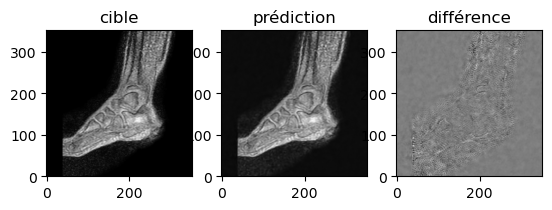

In [21]:
'''
Une prédiction est inférée et reformée à la forme de l'image d'origine
'''

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

gt = data / data.max() * 2 - 1

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Nous sommes capable d'apprendre un encodage satisfaisant pour une fois encore retrouver les hautes fréquences de l'image. 

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | layers     | ModuleList | 373 K 
1 | last_layer | Siren      | 353   
------------------------------------------
374 K     Trainable params
0         Non-trainable params
374 K     Total params
0.748     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 15.15it/s, loss=0.000561, v_num=361]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 14.92it/s, loss=0.000561, v_num=361]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 141.88it/s]


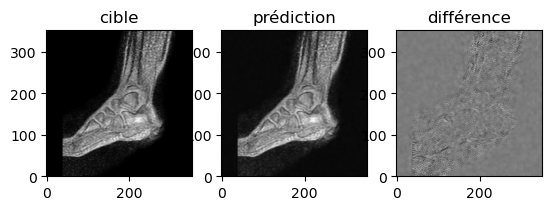

In [22]:
#On peut utiliser la mixed precision pour accélérer les entrainements
model = SirenNet(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=16,
)

trainer.fit(model, train_loader)

loss16 = model.losses[:]

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Attention ! Dans certains cas (entrainements 4D notamment), passer en 32bits->16bits precision peut empêcher le modèle de converger correctement.

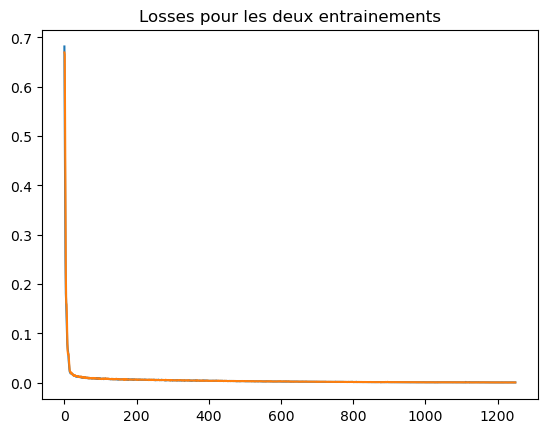

In [23]:
plt.plot(range(len(loss32)), loss32)
plt.plot(range(len(loss16)), loss16)

plt.title('Losses pour les deux entrainements')

plt.show()

Les réseaux de type siren convergent très rapidemment quand ils sont correctement initialisés. Une approche de type initialisation optimale peut permettre d'améliorer encore la convergence.   

Ajoutons maintenant la dimension temporelle. La fonction à approximer devient maintenant f(x, y, t) = I et la minimisation reste la même.

In [8]:
'''
Refaisons la même expérience en intégrant la dimension temporelle
'''
batch_size = 30000
epochs = 50

mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3,:] #largeur, hauteur, nombre de slices, nombre de frames
image_shape = data.shape
dim_in = len(data.shape)

Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() * 2 -1

axes = []
for s in image_shape:
    axes.append(torch.linspace(-1, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | layers     | ModuleList | 374 K 
1 | last_layer | Siren      | 353   
------------------------------------------
374 K     Trainable params
0         Non-trainable params
374 K     Total params
1.498     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s, loss=0.00175, v_num=402]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s, loss=0.00175, v_num=402]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 62/62 [00:01<00:00, 53.84it/s]


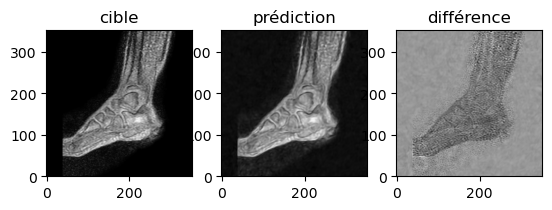

In [9]:
model = SirenNet(dim_in=dim_in,
                 dim_hidden=dim_hidden)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)
pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 7]

gt = data[..., 7]
gt = gt / gt.max() * 2 - 1

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Du flou commence à apparaitre. Essayons également d'interpoler quelques frames intermédiaires

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 120/120 [00:03<00:00, 31.56it/s]


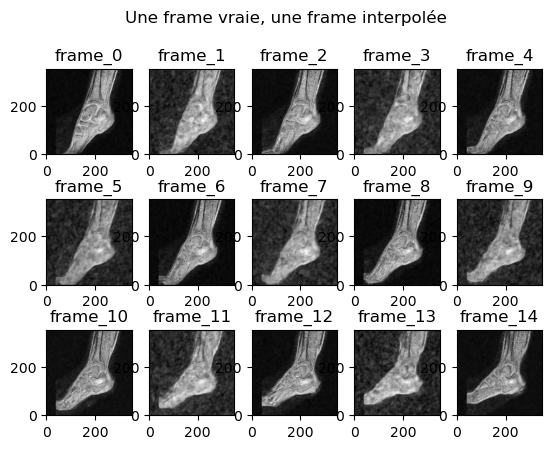

In [11]:
#dense grid
interp_shape = (352, 352, 29)
Y_interp = torch.zeros((np.prod(interp_shape), 1)) #Un mock dataset pour l'interpolation. Pas de backpropagation donc aucun effet de la valeur utilisée

axes = []
for s in interp_shape:
    axes.append(torch.linspace(-1, 1, s))
        
mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)
X_interp = coords.reshape(len(Y_interp), dim_in)    

interp_dataset = torch.utils.data.TensorDataset(X_interp, Y_interp)
interp_loader = torch.utils.data.DataLoader(interp_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

#create an interpolation
interp = torch.concat(trainer.predict(model, interp_loader))

interp_im = interp.reshape(interp_shape)
    
interp_im = interp_im.detach().cpu().numpy()
interp_im = np.array(interp_im, dtype=np.float32)

if len(interp_im.shape) > 3:
    interp_im = interp_im[:,:,3,:]

fig, axes = plt.subplots(3, 5)

fig.suptitle('Une frame vraie, une frame interpolée')

for j in range(3):
    for i in range(5):
        idx = j * 5 + i
        data = interp_im[..., idx]
        axes[j][i].title.set_text(f'frame_{idx}')
        axes[j][i].imshow(data.T, origin="lower", cmap="gray")

plt.show()

Le modèle peine à extrapoler en dehors du domaine d'apprentissage, signe d'un overfit. Comme nous utilisons la totalité de l'image pour l'apprentissage, ce n'est pas une surprise. Pour remédier à ce problème, nous pouvons mettre en place des techniques de régularisation lors de l'apprentissage ou des à priori pour contraindre l'entrainement.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | layers     | ModuleList | 6.0 M 
1 | last_layer | Siren      | 1.4 K 
------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
23.835    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 62/62 [00:10<00:00,  5.67it/s, loss=0.00227, v_num=338]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 62/62 [00:11<00:00,  5.60it/s, loss=0.00227, v_num=338]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 62/62 [00:02<00:00, 21.45it/s]


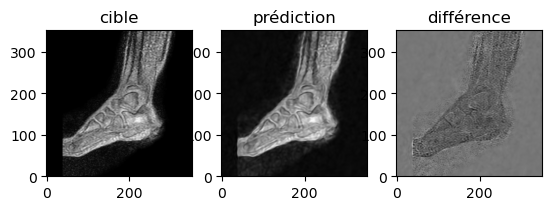

In [11]:
model = SirenNet(dim_in=dim_in,
                 dim_hidden=dim_hidden * 4)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)
pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 7]

gt = data[..., 7]
gt = gt / gt.max() * 2 - 1

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Augmenter le dim_hidden du modèle, et donc son expressivité, permet de récupérer une partie des détails de l'image, mais n'est pas suffisant.

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | layers     | ModuleList | 6.0 M 
1 | last_layer | Siren      | 1.4 K 
------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
23.835    Total estimated model params size (MB)
/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The 

Epoch 149: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s, loss=0.000645, v_num=346]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 21/21 [00:11<00:00,  1.78it/s, loss=0.000645, v_num=346]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:02<00:00,  7.56it/s]


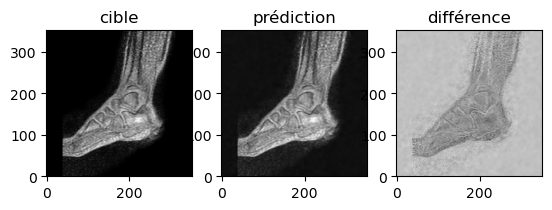

In [12]:
'''
Attention, expérience dure ~30minutes....
'''
batch_size = 30000 * 3
epochs = 50 * 3 #On garde le même nombre de descentes de gradient

mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3,:] #largeur, hauteur, nombre de slices, nombre de frames
image_shape = data.shape
dim_in = len(data.shape)

Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() * 2 -1

axes = []
for s in image_shape:
    axes.append(torch.linspace(-1, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = SirenNet(dim_in=dim_in,
                 dim_hidden=dim_hidden * 4)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)
pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 7]

gt = data[..., 7]
gt = gt /gt.max() * 2 - 1

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Un modulateur peut être utiliser pour enrichir la gamme d'expression du Siren. Cette approche a été proposé par Mehta et al. dans le papier: "Modulated Periodic Activations for Generalizable Local Functional Representations"

In [14]:
'''
Reference: Mehta et al.: Modulated Periodic Activations for Generalizable Local Functional Representations
'''

class Modulator(nn.Module):
    """
    Modulator as per paper 'Modulated periodic activations for generalizable local functional representations'
    """
    def __init__(self, dim_in, dim_hidden, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([])

        for ind in range(num_layers):
            is_first = ind == 0
            dim = dim_in if is_first else (dim_hidden + dim_in)

            self.layers.append(nn.Sequential(nn.Linear(dim, dim_hidden), nn.LeakyReLU()))

    def forward(self, z):
        x = z
        hiddens = []

        for layer in self.layers:
            x = layer(x)
            hiddens.append(x)
            x = torch.cat((x, z), dim=1)

        return tuple(hiddens)

class ModulatedSirenNet(pl.LightningModule):
    """
    Lightning module for modulated siren. Each layer of the modulation is element-wise multiplied with the corresponding siren layer
    """

    def __init__(
        self,
        dim_in=3,
        dim_hidden=352,
        dim_out=1,
        num_layers=4,
        w0=30.0,
        w0_initial=30.0,
        c=12.0,
        use_bias=True,
        final_activation=None,
        lr=1e-4,
        *args,
        **kwargs
    ):
        super().__init__()
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.num_layers = num_layers
        self.w0 = w0
        self.w0_initial = w0_initial
        self.c = c
        self.use_bias = use_bias
        self.final_activation = final_activation
        self.lr = lr
        self.losses = []

        # networks
        
        self.modulator = Modulator(
            dim_in=dim_in, dim_hidden=self.dim_hidden, num_layers=self.num_layers
        )
        self.siren = SirenNet(
            dim_in=self.dim_in,
            dim_hidden=self.dim_hidden,
            dim_out=self.dim_out,
            num_layers=self.num_layers,
            w0=self.w0,
            w0_initial=self.w0_initial,
            c=self.c,
            use_bias=self.use_bias,
            final_activation=self.final_activation,
            lr=self.lr,
        )

    def forward(self, x):
        mods = self.modulator(x)

        mods = cast_tuple(mods, self.num_layers)

        for layer, mod in zip(self.siren.layers, mods):

            x = layer(x)

            x *= mod

        return self.siren.last_layer(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self(x)

        loss = F.mse_loss(z, y)
        self.losses.append(loss.detach().cpu().numpy())

        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)
    


In [ ]:
'''
Les éléments nécessaire à l'entrainement sont déclarés
'''

Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() * 2 - 1

axes = []
for s in image_shape:
    axes.append(torch.linspace(-1, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = ModulatedSirenNet(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)
pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 7]

gt = data[..., 7]
gt = gt /gt.max() * 2 - 1

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Mais ne fonctionne pas pour notre cas (à travailler, il est possible de corriger le modulateur). On peut utiliser un autre type de représentation implicite, le hash encoding

La base du hash encoding est une "simple" hashtable. Dans le modèle que nous allons voir, chaque coordonnée de X est associée à un certain nombre de paramètres répartis dans plusieurs hashtables. Ces paramètres sont appris et vont être ajustés normalement durant la backpropagation. Cet espace de paramètres est une représentation latente qu'un décodeur (un simple MLP) va se charger de décoder en image. Voir l'excellente figure du papier "Instant Neural Graphics Primitives with a Multiresolution Hash Encoding" pour plus de détails.

Il n'y a pas de gestion explicite de collisions dans le cas ou deux coordonnées renvoient la même clé de hash. Le decoder scale avec le nombre de tables de hash mais pas avec la dimension des coordonnées d'entrée.

Le grand avantage de ce modèle est qu'il est très flexible et robuste. Par ailleurs, il scale bien si on ajoute des dimensions.

En revanche, le nombre de paramètres à ajuster est très important (plusieurs millions). Ce modèle converge souvent moins rapidemment que les modèles périodiques (Siren et Random Fourier Features). Par ailleurs, puisque le nombre de paramètres dans les table sde hash est très important, il faut faire beaucoup d'epochs pour tous les ajuster, même si le décoder a déjà convergé. Avec un petit nombre d'epochs, on observe souvent des "trous" lors de la prédiction

Nous allons commencer par utiliser le modèle original proposé par NVIDIA. Pour celà, il faut installer tinycudann à partir du repository suivant: https://github.com/NVlabs/tiny-cuda-nn. 

Une fois la librairie installée (n'oubliez pas de redémarrer votre pc après la mise à jour du PATH pour que tinycuda soit bien pris en compte, ou faites le manuellement), on va initialiser un modèle pytorch_lightning ayant pour base tinycuda.

Ici, on utilise une normalisation entre 0 et 1. L'optimiser reste un Adam, c'est en générale le choix passe partout pour la plupart des modèles avant de choisir un optimiser plus spécialisé le cas échéant.

In [17]:
'''
Reference papers:
    Principe de base et gestion des collisions: Teschner et al. - Optimized Spatial Hashing for Collision Detection .pdf 
    Présentation de Tinycuda: Müller et al. Instant Neural Graphics Primitives with a Multiresolution Hash Encoding // Github repository disponbile sur Nvidia
    Utilisation dans le cadre de la recherche fetale: Junshen et al. NeSVoR: Implicit Neural Representation for Slice-to-Volume Reconstruction in MRI // Github repository disponible


Nous allons utiliser la bibiothèque tinycudann disponible sur le repository de Nvidia. Cette bibiothèque nécéssite impérativement un GPU pour être utilisée.
'''

from encoding import MultiResHashGrid, MultiResHashGridV2 #version full python du hash encoding, V2 pour grilles asymétriques

class HashMLP(pl.LightningModule):
    '''
    Lightning module for HashMLP. 
    '''
    def __init__(
        self,
        dim_in,
        dim_hidden,
        dim_out,
        n_layers,
        encoder_type,
        n_levels,
        n_features_per_level,
        log2_hashmap_size,
        base_resolution,
        finest_resolution,
        per_level_scale,
        interpolation,
        lr,
        *args,
        **kwargs
    ):
        super().__init__()
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.n_layers = n_layers
        self.encoder_type = encoder_type
        self.n_levels = n_levels
        self.n_features_per_level = n_features_per_level
        self.log2_hashmap_size = log2_hashmap_size
        self.base_resolution = base_resolution
        self.finest_resolution = finest_resolution
        self.per_level_scale = per_level_scale
        self.interpolation = interpolation
        self.lr = lr
        self.latents = [] #utilisé pour stocker les représentations intermédiaires lors de la visualisation

        if self.encoder_type == 'tcnn':
            # self.encoder = torch.nn.utils.parametrizations.spectral_norm(tcnn.Encoding(n_input_dims=(self.dim_in), encoding_config= {"otype": "HashGrid", "n_levels": self.n_levels, "n_features_per_level": self.n_features_per_level, "log2_hashmap_size": self.log2_hashmap_size, "base_resolution": self.base_resolution, "per_level_scale": self.per_level_scale, "interpolation": self.interpolation}, dtype=torch.float32), name='params', n_power_iterations=4, eps=1e-12, dim=None)
            self.encoder = tcnn.Encoding(n_input_dims=(self.dim_in), encoding_config= {"otype": "HashGrid", "n_levels": self.n_levels, "n_features_per_level": self.n_features_per_level, "log2_hashmap_size": self.log2_hashmap_size, "base_resolution": self.base_resolution, "per_level_scale": self.per_level_scale, "interpolation": self.interpolation}, dtype=torch.float32)
        else: 
            if isinstance(self.base_resolution, int):
                self.encoder = MultiResHashGrid(
                    dim=self.dim_in, 
                    n_levels=self.n_levels, 
                    n_features_per_level=self.n_features_per_level,
                    log2_hashmap_size=self.log2_hashmap_size,
                    base_resolution=self.base_resolution,
                    finest_resolution=self.finest_resolution,
                    )
            else:
                self.encoder = MultiResHashGridV2(
                    dim=self.dim_in, 
                    n_levels=self.n_levels, 
                    n_features_per_level=self.n_features_per_level,
                    log2_hashmap_size=self.log2_hashmap_size,
                    base_resolution=self.base_resolution,
                    finest_resolution=self.finest_resolution,
                    )
        
        self.encoding_dim_out = self.n_levels * self.n_features_per_level

        self.decoder = torch.nn.ModuleList()
        for i in range(self.n_layers):
            if i == 0:
                in_features = self.encoding_dim_out
            else:
                in_features = self.dim_hidden
                
            if encoder_type == 'tcnn':
                block = torch.nn.Sequential(
                    torch.nn.Linear(in_features=in_features, out_features=self.dim_out if i == (self.n_layers - 1) else self.dim_hidden),
                    torch.nn.GELU() #More robust than RELU, prevent gradient vanishing
                )
            else:
                block = torch.nn.Sequential(
                    torch.nn.utils.parametrizations.spectral_norm(torch.nn.Linear(in_features=in_features, out_features=self.dim_out if i == (self.n_layers - 1) else self.dim_hidden), n_power_iterations=4, eps=1e-12, dim=None),
                    torch.nn.BatchNorm1d(num_features=self.dim_out if i == (self.n_layers - 1) else self.dim_hidden), #you can do batchnorm 3D + 1D and cat after
                    torch.nn.GELU() #More robust than RELU, prevent gradient vanishing
                )
                
            self.decoder.append(block)
            

    def forward(self, x):
        x = self.encoder(x)
        for idx, layer in enumerate(self.decoder):
            x = layer(x)
        return x

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr) #weight_decay=1e-5
        return self.optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch

        y_pred = self.forward(x)

        loss = F.mse_loss(y_pred, y)

        self.log("train_loss", loss)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        z = self.encoder(x)
        self.latents.append(z)
        return y_pred

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Encoding   | 1.1 M 
1 | decoder | ModuleList | 2.2 K 
---------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.490     Total estimated model params size (MB)
/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of train

Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 18.40it/s, loss=9.11e-05, v_num=362]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 17.27it/s, loss=9.11e-05, v_num=362]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 135.73it/s]


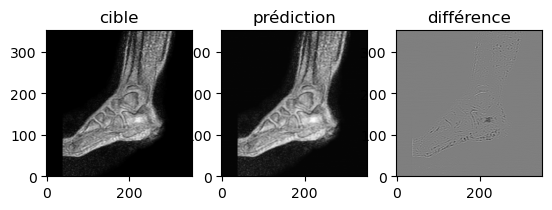

In [25]:

#Parametres pour l'entrainement et le réseau
batch_size = 5000
epochs = 50
dim_hidden = 64
dim_out = 1
n_layers = 2
encoder_type = 'tcnn'
n_levels=16  #16
base_resolution= 64 
per_level_scale = 1.14 #1.3 #1.14
n_features_per_level = 2
log2_hashmap_size = 16
finest_resolution = None #used for non tcnn version
interpolation = 'Linear'

#Première étape, charger une image IRM
image_path = '/mnt/Data/Equinus_BIDS_dataset/sourcedata/sub_E01/sub_E01_dynamic_MovieClear_active_run_12.nii.gz'

mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3, 7] #commencons en 2D
image_shape = data.shape
dim_in = len(data.shape)

#/!\ Normalisation -1, 1 -> 0, 1
Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() 

axes = []
for s in image_shape:
    axes.append(torch.linspace(0, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = HashMLP(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    n_layers=n_layers,
    encoder_type=encoder_type,
    n_levels=n_levels,
    n_features_per_level=n_features_per_level, #1
    log2_hashmap_size=log2_hashmap_size,
    base_resolution=base_resolution,
    finest_resolution=finest_resolution,
    per_level_scale=per_level_scale,
    lr=1e-4,
    interpolation=interpolation
)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

fig, axes = plt.subplots(1, 3)

gt = data / data.max()

diff = im - gt

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Encore une fois, on retrouve la fonction f(x, y) = i. Ici, ce sont les paramètres appris des tables de hash qui permettent d'approximer la fonction cible.

Avec peu d'epochs, il est fréquent d'observer des spots sur l'image finale, car le nombre de paramètres dans la table de hash est très important. Ces réseaux convergent typiquement moins vite que les réseaux à activation périodique.

Nous allons maintenant visualiser les représentations intermédiaires du réseau pour chaque niveau définis

In [27]:
#On passe le dataset complet en une fois, pour que les représentations intermédaires soient également complètes
test_loader = torch.utils.data.DataLoader(dataset, batch_size= 352 * 352, shuffle=False, num_workers=os.cpu_count())
model.latents = []
pred = torch.concat(trainer.predict(model, test_loader))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 25it [00:00, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.18it/s] 


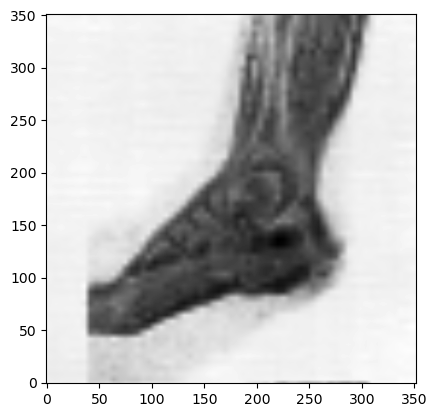

In [28]:
latents = model.latents
len(latents)
im = latents[0][:,0].reshape(352, 352)
plt.imshow(im.cpu().detach().numpy().T, origin='lower', cmap='gray')

On retrouve une image similaire à notre image cible

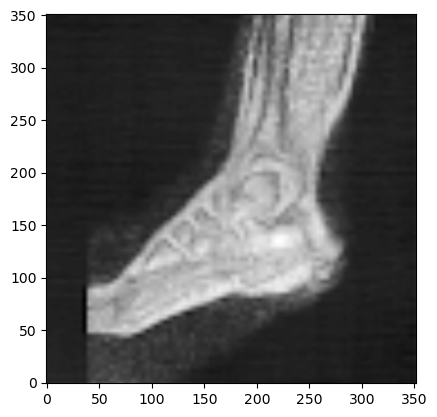

In [29]:
latents = model.latents
len(latents)
im = latents[0][:,5].reshape(352, 352)
plt.imshow(im.cpu().detach().numpy().T, origin='lower', cmap='gray')

On retrouve la forme de l'image cible, l'information étant distribué sur les différents niveaux de l'espace de paramètres. Les informations basse résolution ont tendance à être stockés sur les premiers niveaux, tandis que les détails haute résolution se retrouvent dans les tables ultérieures. Plus on a de niveau et/ou de features par niveau, plus l'information sera distribuée entre les différents niveau et moins chaque niveau sera cohérent. 

Comme la taille du decodeur n'est soumis qu'au nombre de tables hash (ainsi que le nombre de paramètres par table), on peut facilement passer en dimension supérieure

In [40]:
#Parametres pour l'entrainement et le réseau
batch_size = 20000 #5000
epochs = 50 #50
dim_hidden = 64
dim_out = 1
n_layers = 2
encoder_type = 'tcnn'
n_levels=16  #16
base_resolution= 64 
per_level_scale = 1.14 #1.3 #1.14
n_features_per_level = 2
log2_hashmap_size = 23
finest_resolution = None #used for non tcnn version
interpolation = 'Linear'

#Première étape, charger une image IRM
image_path = '/mnt/Data/Equinus_BIDS_dataset/sourcedata/sub_E01/sub_E01_dynamic_MovieClear_active_run_12.nii.gz'

mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3,:]
image_shape = data.shape
dim_in = len(data.shape)

#/!\ Normalisation -1, 1 -> 0, 1
Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() 

axes = []
for s in image_shape:
    axes.append(torch.linspace(0, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = HashMLP(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    n_layers=n_layers,
    encoder_type=encoder_type,
    n_levels=n_levels,
    n_features_per_level=n_features_per_level, #1
    log2_hashmap_size=log2_hashmap_size,
    base_resolution=base_resolution,
    finest_resolution=finest_resolution,
    per_level_scale=per_level_scale,
    lr=1e-4,
    interpolation=interpolation
)
trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Encoding   | 154 M 
1 | decoder | ModuleList | 2.2 K 
---------------------------------------
154 M     Trainable params
0         Non-trainable params
154 M     Total params
617.034   Total estimated model params size (MB)


Epoch 49: 100%|██████████| 93/93 [00:06<00:00, 15.30it/s, loss=1.09e-06, v_num=364]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 93/93 [00:10<00:00,  9.24it/s, loss=1.09e-06, v_num=364]


In [57]:
mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3,:]
image_shape = data.shape
dim_in = len(data.shape)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 93/93 [00:02<00:00, 45.15it/s]


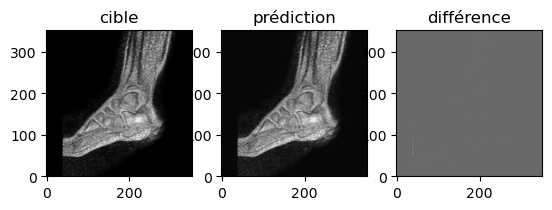

In [58]:
pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(image_shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im_frame = im[..., 7].copy()

gt = data.copy() / data.max()
gt = gt[..., 7]

diff = im_frame - gt

fig, axes = plt.subplots(1, 3)

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im_frame.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()


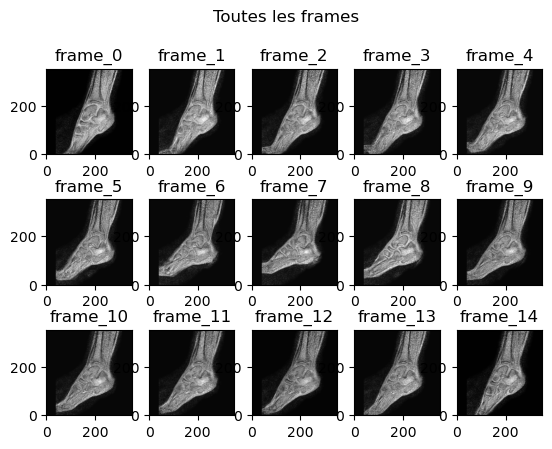

In [62]:
fig, axes = plt.subplots(3, 5)

fig.suptitle('Toutes les frames')

for j in range(3):
    for i in range(5):
        idx = j * 5 + i
        data = im[..., idx]
        axes[j][i].title.set_text(f'frame_{idx}')
        axes[j][i].imshow(data.T, origin="lower", cmap="gray")

plt.show()

Vous pouvez essayer de réaliser cet entrainement en précision=16 (au niveau de la déclaration du trainer) et voir l'effet sur la qualité d'image

Essayons d'interpoler quelques frames temporelles

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 180/180 [00:04<00:00, 37.52it/s]


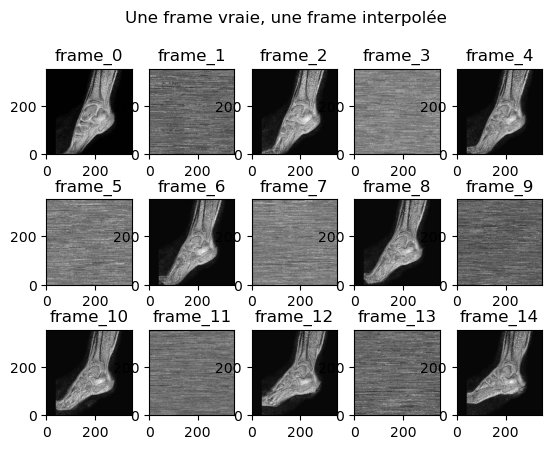

In [64]:
#dense grid
interp_shape = (352, 352, 29)
Y_interp = torch.zeros((np.prod(interp_shape), 1)) #Un mock dataset pour l'interpolation. Pas de backpropagation donc aucun effet de la valeur utilisée

axes = []
for s in interp_shape:
    axes.append(torch.linspace(0, 1, s))
        
mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)
X_interp = coords.reshape(len(Y_interp), dim_in)    

interp_dataset = torch.utils.data.TensorDataset(X_interp, Y_interp)
interp_loader = torch.utils.data.DataLoader(interp_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

#create an interpolation
interp = torch.concat(trainer.predict(model, interp_loader))

interp_im = interp.reshape(interp_shape)
    
interp_im = interp_im.detach().cpu().numpy()
interp_im = np.array(interp_im, dtype=np.float32)

if len(interp_im.shape) > 3:
    interp_im = interp_im[:,:,3,:]

fig, axes = plt.subplots(3, 5)

fig.suptitle('Une frame vraie, une frame interpolée')

for j in range(3):
    for i in range(5):
        idx = j * 5 + i
        data = interp_im[..., idx]
        axes[j][i].title.set_text(f'frame_{idx}')
        axes[j][i].imshow(data.T, origin="lower", cmap="gray")

plt.show()

Les frames intermédiaires sont vides, voyons pourquoi, Nous allons réentrainer un model simplifié pour voir les latents de manière plus simple. Dans cet exemple, on va forcer un seul paramètre par niveau et par point, et garder un nombre de niveaux faible. Ce qui se traduit par un espace H qui "doit" être plus structuré (l'information est moins distribuée sur les différents niveaux) et que l'on peut visualiser plus facilement. 

In [65]:
#Parametres pour l'entrainement et le réseau
batch_size = 20000 #5000
epochs = 50 #50
dim_hidden = 64
dim_out = 1
n_layers = 2
encoder_type = 'tcnn'
n_levels=8  #16
base_resolution= 64 
per_level_scale = 1.14 #1.3 #1.14
n_features_per_level = 1
log2_hashmap_size = 23
finest_resolution = None #used for non tcnn version
interpolation = 'Linear'

#Première étape, charger une image IRM
image_path = '/mnt/Data/Equinus_BIDS_dataset/sourcedata/sub_E01/sub_E01_dynamic_MovieClear_active_run_12.nii.gz'

mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3,:]
image_shape = data.shape
dim_in = len(data.shape)

#/!\ Normalisation -1, 1 -> 0, 1
Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() 

axes = []
for s in image_shape:
    axes.append(torch.linspace(0, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = HashMLP(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    n_layers=n_layers,
    encoder_type=encoder_type,
    n_levels=n_levels,
    n_features_per_level=n_features_per_level, #1
    log2_hashmap_size=log2_hashmap_size,
    base_resolution=base_resolution,
    finest_resolution=finest_resolution,
    per_level_scale=per_level_scale,
    lr=1e-4,
    interpolation=interpolation
)
trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Encoding   | 12.3 M
1 | decoder | ModuleList | 641   
---------------------------------------
12.3 M    Trainable params
0         Non-trainable params
12.3 M    Total params
49.120    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 93/93 [00:05<00:00, 15.75it/s, loss=7.56e-05, v_num=366]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 93/93 [00:06<00:00, 14.88it/s, loss=7.56e-05, v_num=366]


In [66]:

hash_encoding = model.encoder.params.detach()
low_freq = hash_encoding[:(64 * 64 * 64)] #on récupère le nombre de points correspondant au premier niveau
len(low_freq)

262144

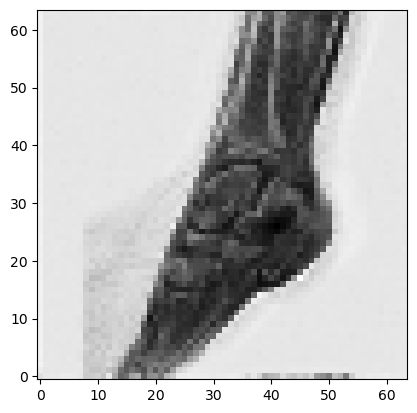

In [68]:
#on récupère la première table de paramètres
low_freq = low_freq.reshape(64, 64, 64)
low_freq = np.array(low_freq, dtype=np.float32)

plt.imshow(low_freq[0,:,:], origin='lower', cmap='gray')

    

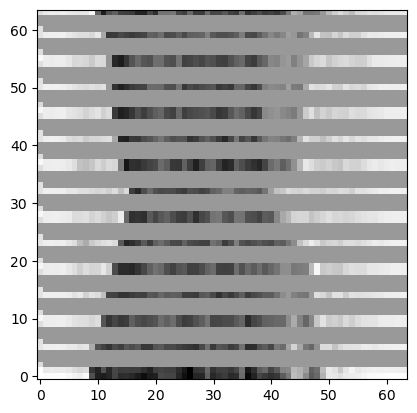

In [69]:
#regardons une autre orientation
low_freq = low_freq.reshape(64, 64, 64)
low_freq = np.array(low_freq, dtype=np.float32)

plt.imshow(low_freq[:,:,32], origin='lower', cmap='gray')


Une grosses partie de l'espace des paramètres est vide !

Nous voyons bien que l'espace de paramètres est organisé en "tranches" dans la dimension des frames, et que la plupart de celles-ci sont vides. Tinycuda force un espace de paramètre cubic, mais nous pouvons adapter le code pour autoriser des formes arbitraires via le code python contenu dans "encoding".

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | MultiResHashGridV2 | 61.5 M
1 | decoder | ModuleList         | 2.3 K 
-----------------------------------------------
61.5 M    Trainable params
0         Non-trainable params
61.5 M    Total params
246.100   Total estimated model params size (MB)


Epoch 49: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s, loss=0.000382, v_num=367]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 93/93 [00:11<00:00,  8.33it/s, loss=0.000382, v_num=367]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 93/93 [00:03<00:00, 24.09it/s]


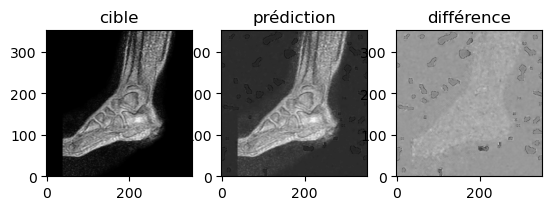

In [70]:
#Parametres pour l'entrainement et le réseau
batch_size = 20000
epochs = 50 
dim_hidden = 64
dim_out = 1
n_layers = 2
encoder_type = 'hash' #version pure python
n_levels = 8
n_features_per_level = 2
log2_hashmap_size=23
base_resolution= (64, 64, 5) #Je déclare une résolution plus faible pour les frames, le model bascule automatiquement sur l'encoding correspondant.
finest_resolution = (512, 512, 15) #Paramètre utilisé pour la version non-tinycuda
interpolation = 'Linear'

#Première étape, charger une image IRM
image_path = '/mnt/Data/Equinus_BIDS_dataset/sourcedata/sub_E01/sub_E01_dynamic_MovieClear_active_run_12.nii.gz'

mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3,:] #commencons en 3D
image_shape = data.shape
dim_in = len(data.shape)

#/!\ Normalisation -1, 1 -> 0, 1
Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() 

axes = []
for s in image_shape:
    axes.append(torch.linspace(0, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = HashMLP(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    n_layers=n_layers,
    encoder_type=encoder_type,
    n_levels=n_levels,
    n_features_per_level=n_features_per_level,
    log2_hashmap_size=log2_hashmap_size, 
    base_resolution=base_resolution,
    finest_resolution=finest_resolution,
    per_level_scale=per_level_scale,
    lr=1e-4,
    interpolation=interpolation
)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 7]

gt = data / data.max()
gt = gt[..., 7]

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 180/180 [00:06<00:00, 25.97it/s]


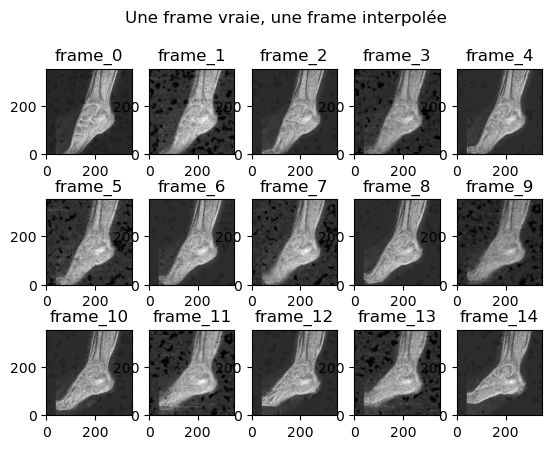

In [71]:
#dense grid
interp_shape = (352, 352, 29)
Y_interp = torch.zeros((np.prod(interp_shape), 1)) #mock dataset for interpolation loader

axes = []
for s in interp_shape:
    axes.append(torch.linspace(0, 1, s))
        
mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)
X_interp = coords.reshape(len(Y_interp), dim_in)    

interp_dataset = torch.utils.data.TensorDataset(X_interp, Y_interp)
interp_loader = torch.utils.data.DataLoader(interp_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

#create an interpolation
interp = torch.concat(trainer.predict(model, interp_loader))

interp_im = interp.reshape(interp_shape)
    
interp_im = interp_im.detach().cpu().numpy()
interp_im = np.array(interp_im, dtype=np.float32)

if len(interp_im.shape) > 3:
    interp_im = interp_im[:,:,3,:]

fig, axes = plt.subplots(3, 5)

fig.suptitle('Une frame vraie, une frame interpolée')

for j in range(3):
    for i in range(5):
        idx = j * 5 + i
        data = interp_im[..., idx]
        axes[j][i].title.set_text(f'frame_{idx}')
        axes[j][i].imshow(data.T, origin="lower", cmap="gray")

plt.show()

Les frames intermédiaires sont (presque) correctement interpolées !

Pour obtenir des résultats plus intéressants, il faut mettre en place différentes stratégies de régularisation et les ajuster pour obtenir un espace de paramètres cohérent. 

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | MultiResHashGridV2 | 6.0 M 
1 | decoder | ModuleList         | 1.2 K 
-----------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
24.041    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 93/93 [00:04<00:00, 20.65it/s, loss=0.00054, v_num=404] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 93/93 [00:04<00:00, 20.07it/s, loss=0.00054, v_num=404]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 93/93 [00:01<00:00, 52.09it/s]


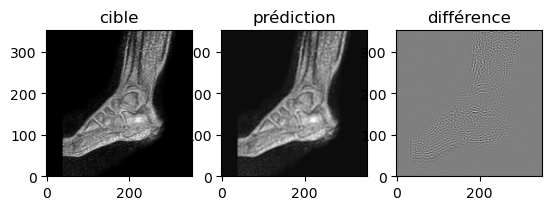

In [3]:
'''
Reference papers:
    Principe de base et gestion des collisions: Teschner et al. - Optimized Spatial Hashing for Collision Detection .pdf 
    Présentation de Tinycuda: Müller et al. Instant Neural Graphics Primitives with a Multiresolution Hash Encoding // Github repository disponbile sur Nvidia
    Utilisation dans le cadre de la recherche fetale: Junshen et al. NeSVoR: Implicit Neural Representation for Slice-to-Volume Reconstruction in MRI // Github repository disponible


Nous allons utiliser la bibiothèque tinycudann disponible sur le repository de Nvidia. Cette bibiothèque nécéssite impérativement un GPU pour être utilisée.
'''

from encoding import MultiResHashGrid, MultiResHashGridV2 #version full python du hash encoding, V2 pour grilles asymétriques

class HashMLP(pl.LightningModule):
    '''
    Lightning module for HashMLP. 
    '''
    def __init__(
        self,
        dim_in,
        dim_hidden,
        dim_out,
        n_layers,
        encoder_type,
        n_levels,
        n_features_per_level,
        log2_hashmap_size,
        base_resolution,
        finest_resolution,
        per_level_scale,
        interpolation,
        lr,
        *args,
        **kwargs
    ):
        super().__init__()
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.n_layers = n_layers
        self.encoder_type = encoder_type
        self.n_levels = n_levels
        self.n_features_per_level = n_features_per_level
        self.log2_hashmap_size = log2_hashmap_size
        self.base_resolution = base_resolution
        self.finest_resolution = finest_resolution
        self.per_level_scale = per_level_scale
        self.interpolation = interpolation
        self.lr = lr
        self.latents = [] #utilisé pour stocker les représentations intermédiaires lors de la visualisation

        if self.encoder_type == 'tcnn':
            # self.encoder = torch.nn.utils.parametrizations.spectral_norm(tcnn.Encoding(n_input_dims=(self.dim_in), encoding_config= {"otype": "HashGrid", "n_levels": self.n_levels, "n_features_per_level": self.n_features_per_level, "log2_hashmap_size": self.log2_hashmap_size, "base_resolution": self.base_resolution, "per_level_scale": self.per_level_scale, "interpolation": self.interpolation}, dtype=torch.float32), name='params', n_power_iterations=4, eps=1e-12, dim=None)
            self.encoder = tcnn.Encoding(n_input_dims=(self.dim_in), encoding_config= {"otype": "HashGrid", "n_levels": self.n_levels, "n_features_per_level": self.n_features_per_level, "log2_hashmap_size": self.log2_hashmap_size, "base_resolution": self.base_resolution, "per_level_scale": self.per_level_scale, "interpolation": self.interpolation}, dtype=torch.float32)
        else: 
            if isinstance(self.base_resolution, int):
                self.encoder = MultiResHashGrid(
                    dim=self.dim_in, 
                    n_levels=self.n_levels, 
                    n_features_per_level=self.n_features_per_level,
                    log2_hashmap_size=self.log2_hashmap_size,
                    base_resolution=self.base_resolution,
                    finest_resolution=self.finest_resolution,
                    )
            else:
                self.encoder = MultiResHashGridV2(
                    dim=self.dim_in, 
                    n_levels=self.n_levels, 
                    n_features_per_level=self.n_features_per_level,
                    log2_hashmap_size=self.log2_hashmap_size,
                    base_resolution=self.base_resolution,
                    finest_resolution=self.finest_resolution,
                    )
        
        self.encoding_dim_out = self.n_levels * self.n_features_per_level

        self.decoder = torch.nn.ModuleList()
        for i in range(self.n_layers):
            if i == 0:
                in_features = self.encoding_dim_out
            else:
                in_features = self.dim_hidden
                
            if encoder_type == 'hash':
                block = torch.nn.Sequential(
                    torch.nn.Linear(in_features=in_features, out_features=self.dim_out if i == (self.n_layers - 1) else self.dim_hidden),
                    torch.nn.GELU() #More robust than RELU, prevent gradient vanishing
                )
            else:
                block = torch.nn.Sequential(
                    torch.nn.utils.parametrizations.spectral_norm(torch.nn.Linear(in_features=in_features, out_features=self.dim_out if i == (self.n_layers - 1) else self.dim_hidden), n_power_iterations=4, eps=1e-12, dim=None),
                    torch.nn.BatchNorm1d(num_features=self.dim_out if i == (self.n_layers - 1) else self.dim_hidden), #you can do batchnorm 3D + 1D and cat after
                    torch.nn.GELU() #More robust than RELU, prevent gradient vanishing
                )
                
            self.decoder.append(block)
            

    def forward(self, x):
        x = self.encoder(x)
        for idx, layer in enumerate(self.decoder):
            x = layer(x)
        return x

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr) #weight_decay=1e-5
        return self.optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch

        y_pred = self.forward(x)

        loss = F.mse_loss(y_pred, y)

        self.log("train_loss", loss)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        z = self.encoder(x)
        self.latents.append(z)
        return y_pred
    
#Parametres pour l'entrainement et le réseau
batch_size = 20000
epochs = 50 
dim_hidden = 64
dim_out = 1
n_layers = 2
encoder_type = 'hash' #version pure python
n_levels = 8
n_features_per_level = 2
per_level_scale = 2 #not used with hash
log2_hashmap_size=23
base_resolution= (64, 64, 5) #Je déclare une résolution plus faible pour les frames, le model bascule automatiquement sur l'encoding correspondant.
finest_resolution = (512, 512, 15) #Paramètre utilisé pour la version non-tinycuda
interpolation = 'Linear'

#Première étape, charger une image IRM
image_path = '/mnt/Data/Equinus_BIDS_dataset/sourcedata/sub_E01/sub_E01_dynamic_MovieClear_active_run_12.nii.gz'

mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3,:] #commencons en 3D
image_shape = data.shape
dim_in = len(data.shape)

#/!\ Normalisation -1, 1 -> 0, 1
Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() 

axes = []
for s in image_shape:
    axes.append(torch.linspace(0, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = HashMLP(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    n_layers=n_layers,
    encoder_type=encoder_type,
    n_levels=n_levels,
    n_features_per_level=n_features_per_level,
    log2_hashmap_size=log2_hashmap_size, 
    base_resolution=base_resolution,
    finest_resolution=finest_resolution,
    per_level_scale=per_level_scale,
    lr=1e-4,
    interpolation=interpolation
)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 7]

gt = data / data.max()
gt = gt[..., 7]

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].title.set_text('cible')
axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].title.set_text('prédiction')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].title.set_text('différence')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 180/180 [00:03<00:00, 55.47it/s]


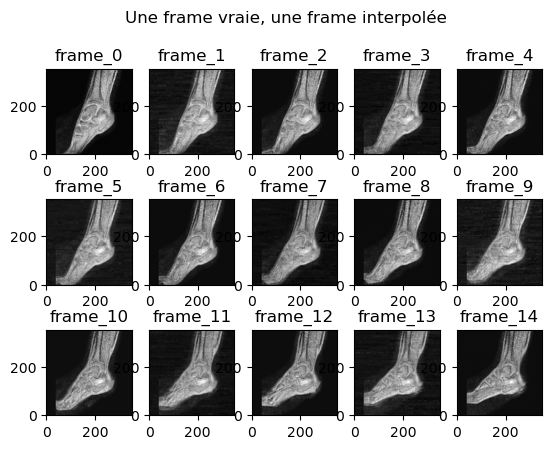

In [4]:
#dense grid
interp_shape = (352, 352, 29)
Y_interp = torch.zeros((np.prod(interp_shape), 1)) #mock dataset for interpolation loader

axes = []
for s in interp_shape:
    axes.append(torch.linspace(0, 1, s))
        
mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)
X_interp = coords.reshape(len(Y_interp), dim_in)    

interp_dataset = torch.utils.data.TensorDataset(X_interp, Y_interp)
interp_loader = torch.utils.data.DataLoader(interp_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

#create an interpolation
interp = torch.concat(trainer.predict(model, interp_loader))

interp_im = interp.reshape(interp_shape)
    
interp_im = interp_im.detach().cpu().numpy()
interp_im = np.array(interp_im, dtype=np.float32)

if len(interp_im.shape) > 3:
    interp_im = interp_im[:,:,3,:]

fig, axes = plt.subplots(3, 5)

fig.suptitle('Une frame vraie, une frame interpolée')

for j in range(3):
    for i in range(5):
        idx = j * 5 + i
        data = interp_im[..., idx]
        axes[j][i].title.set_text(f'frame_{idx}')
        axes[j][i].imshow(data.T, origin="lower", cmap="gray")

plt.show()

En jouant avec les différents paramètres de régularisation, nous pouvons approcher une solution qui extrapole correctement en dehors du domaine d'apprentissage.